## A demonstration of backdrop masking

In [1]:
from backdrop import *

import torch
import torch.nn as nn

### Simple masking example.

##### Define x with 3 dimensions and let's say we want to mask on the 2nd dimension.

In [2]:
# Use requires_grad = True for demonstration so we can see what parts of the data are affected later.
x = Variable(torch.ones([1,4,4]),requires_grad = True)

##### Define the masking layer with 75% masking probability. 
##### Note mask_dims is the list of the dimensions for which we would want to implement masking.

In [3]:
#In this case we want to mask along the second dimension of the input.
my_mask = mask_mod(mask_prob=0.5, mask_dims = [1])
my_mask.verbose = True #Prints out the generated mask every time.

##### Pass the variable x through the mask. The mask is normalized by the number of its nonzero elements.

In [4]:
y = my_mask(x)

Generated mask with shape:  torch.Size([1, 4])
The generate mask is:  [0. 0. 2. 2.]
-------------------------------------------------- 



##### y is identical to x. The mask is transparent during the forward pass.

In [5]:
print(y)

Variable containing:
(0 ,.,.) = 
  1  1  1  1
  1  1  1  1
  1  1  1  1
  1  1  1  1
[torch.FloatTensor of size 1x4x4]



##### But it blocks the gradient along the backward pass. Note the normalization. The nonzero elements are the same as the mask's.

In [6]:
y.sum().backward()
print(x.grad)
x.grad.data.zero_();

Variable containing:
(0 ,.,.) = 
  0  0  2  2
  0  0  2  2
  0  0  2  2
  0  0  2  2
[torch.FloatTensor of size 1x4x4]



### More complicated masking example.

##### Define x with 4 dimensions and mask along the last two.

In [7]:
from backdrop import *

import torch
import torch.nn as nn

In [8]:
# Use requires_grad = True for demonstration so we can see what parts of the data are affected later.
x = Variable(torch.randn([1,1,1024,1024]),requires_grad = True)

##### Define two masking layer with 50% and 90% masking probability.

In [9]:
mask_fine = mask_mod(mask_prob=0.3, mask_dims = [2,3])
mask_coarse = mask_mod(mask_prob=0.95, mask_dims = [2,3])

##### Define a sequential network with the two masks in there.

In [10]:
# The strides and kernel size are chosen here to give a crisp mask definition. If kernel_size > stride, the masks will bleed into larger regions.

net = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=64,kernel_size=5, stride=2,padding=2),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=2, stride=2),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=2, stride=2),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=2, stride=2),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=2, stride=2),nn.ReLU(),
                    mask_fine,
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=2, stride=2),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=2, stride=2),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=2, stride=2),nn.ReLU(),
                    mask_coarse)

##### Pass the variable x through the network.

In [11]:
y = net(x)
# dummy loss function
loss = y.sum()
loss.backward()

##### Let's look at the gradients that made it all the way back to x.

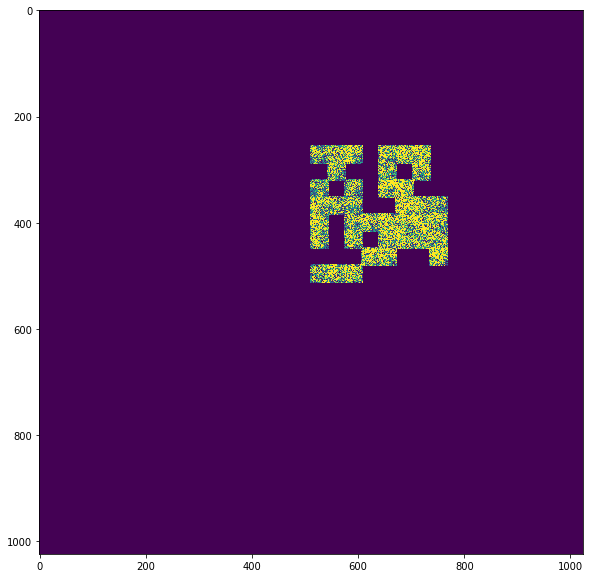

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(x.grad.data.squeeze().cpu().abs().numpy(),vmax=0.0003)
plt.show()
x.grad.data.zero_();

##### We see the product of the two masks at the different scales.

#### We can also specify where the mask is. (for diagnosis or variance checking)

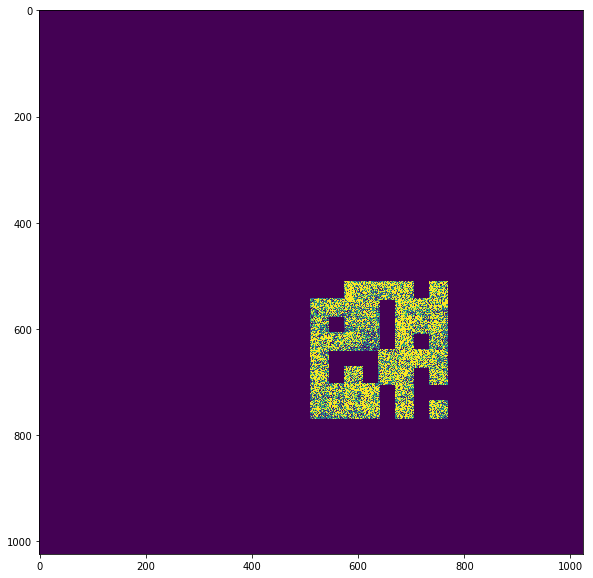

In [13]:
mask_coarse.mask_el=[0,0,2,2]

y = net(x)
# dummy loss function
loss = y.sum()
loss.backward()

plt.figure(figsize=(10,10))
plt.imshow(x.grad.data.squeeze().cpu().abs().numpy(),vmax=0.0003)
plt.show()
x.grad.data.zero_();

mask_coarse.mask_el=None # Revert back to random

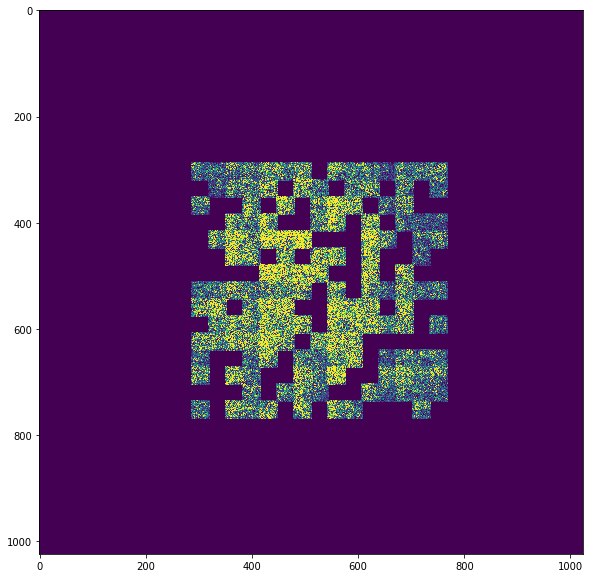

In [14]:
# If the strides and kernel sizes are not chosen as before. 
# Same network just larger kernels for the later convs with padding to give the same size

net = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=64,kernel_size=5, stride=2,padding=2),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=2, stride=2),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=2, stride=2),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=2, stride=2),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=2, stride=2),nn.ReLU(),
                    mask_fine,
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, stride=2,padding=1),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, stride=2,padding=1),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, stride=2,padding=1),nn.ReLU(),
                    mask_coarse)

mask_coarse.mask_el=[0,0,2,2]

y = net(x)
# dummy loss function
loss = y.sum()
loss.backward()

plt.figure(figsize=(10,10))
plt.imshow(x.grad.data.squeeze().cpu().abs().numpy(),vmax=0.0003)
plt.show()
x.grad.data.zero_();

mask_coarse.mask_el=None # Revert back to random

#### As expected the receptor field is larger but the gradients drop off as we approach the boundary.

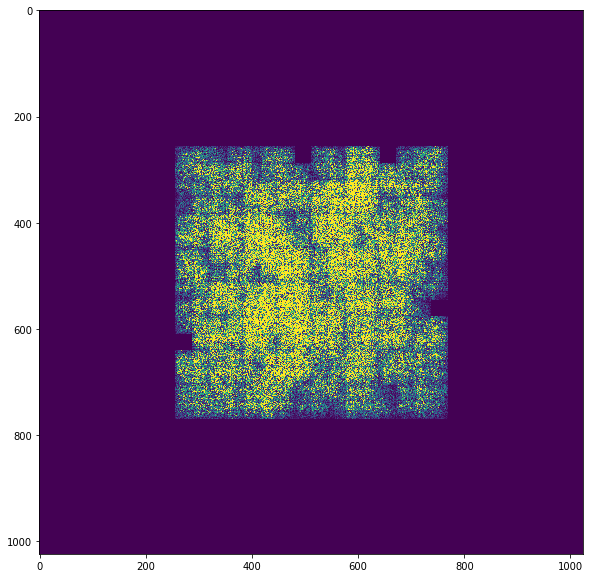

In [15]:
# If we also increase the kernel sizes for the smaller patches:

net = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=64,kernel_size=5, stride=2,padding=2),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, stride=2,padding=1),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, stride=2,padding=1),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, stride=2,padding=1),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, stride=2,padding=1),nn.ReLU(),
                    mask_fine,
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, stride=2,padding=1),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, stride=2,padding=1),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, stride=2,padding=1),nn.ReLU(),
                    mask_coarse)

mask_coarse.mask_el=[0,0,2,2]

y = net(x)
# dummy loss function
loss = y.sum()
loss.backward()

plt.figure(figsize=(10,10))
plt.imshow(x.grad.data.squeeze().cpu().abs().numpy(),vmax=0.0003)
plt.show()
x.grad.data.zero_();

mask_coarse.mask_el=None # Revert back to random

##### The receptor fields get completely washed out unless the mask probability is very high.

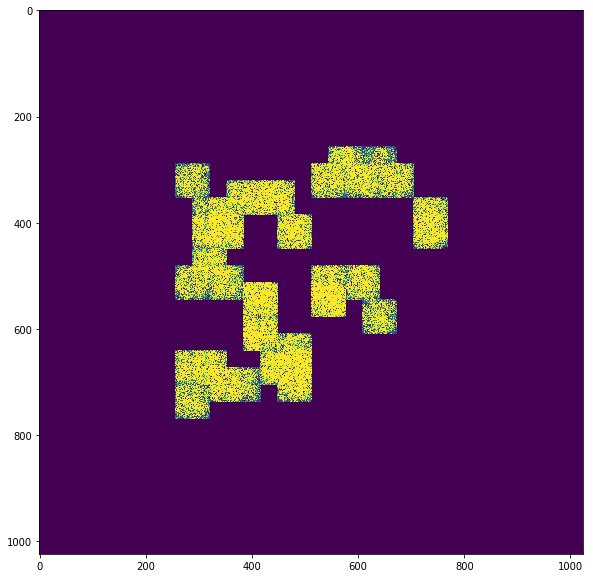

In [16]:
# Same as above but with higher fine mask probability.

mask_fine.mask_prob=0.85

net = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=64,kernel_size=5, stride=2,padding=2),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, stride=2,padding=1),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, stride=2,padding=1),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, stride=2,padding=1),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, stride=2,padding=1),nn.ReLU(),
                    mask_fine,
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, stride=2,padding=1),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, stride=2,padding=1),nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3, stride=2,padding=1),nn.ReLU(),
                    mask_coarse)

mask_coarse.mask_el=[0,0,2,2]

y = net(x)
# dummy loss function
loss = y.sum()
loss.backward()

plt.figure(figsize=(10,10))
plt.imshow(x.grad.data.squeeze().cpu().abs().numpy(),vmax=0.0003)
plt.show()
x.grad.data.zero_();

mask_coarse.mask_el=None # Revert back to random

#### Also note that the regions start overlapping.